In [1]:
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions
from gym_anytrading.envs import ForexEnv, StocksEnv

# stable-baselines3
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
warnings.filterwarnings('ignore')
import quantstats as qs
from dotenv import load_dotenv
import os
plt.style.use('ggplot')
load_dotenv()

True

In [15]:
client = oandapyV20.API(access_token=os.getenv("OANDA_ACCESS_TOKEN"))

params = {'granularity': 'M1', 'count': 200}
r = instruments.InstrumentsCandles(instrument="USD_JPY",
                                   params=params)
client.request(r)

data = [{'Time': d['time'], # time is in UTC by default
         'High': d['mid']['h'], 
         'Close': d['mid']['c'], 
         'Low': d['mid']['l'], 
         'Open': d['mid']['o'], 
         'Volume': d['volume']} 
        for d in r.response['candles']]

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)
df.set_index('Time', inplace=True)
df[['High', 'Close', 'Low', 'Open', 'Volume']] = df[['High', 'Close', 'Low', 'Open', 'Volume']].apply(pd.to_numeric)

In [17]:
df

,High,Close,Low,Open,Volume
Time,,,,,
2024-04-01T13:01:00.000000000Z,151.466,151.466,151.456,151.456,59
2024-04-01T13:02:00.000000000Z,151.468,151.466,151.464,151.464,50
2024-04-01T13:03:00.000000000Z,151.474,151.472,151.466,151.466,52
2024-04-01T13:04:00.000000000Z,151.478,151.468,151.466,151.470,79
2024-04-01T13:05:00.000000000Z,151.467,151.456,151.456,151.465,86
...,...,...,...,...,...
2024-04-01T16:16:00.000000000Z,151.704,151.697,151.694,151.703,39
2024-04-01T16:17:00.000000000Z,151.712,151.697,151.697,151.697,77
2024-04-01T16:18:00.000000000Z,151.702,151.702,151.683,151.698,63


In [18]:
# SMA
df["SMA"] = df["Close"].rolling(window=5).mean()

# RSI
delta = df["Close"].diff()
gain = (delta.where(delta > 0, 0)).ewm(span=5).mean()
loss = (-delta.where(delta < 0, 0)).ewm(span=5).mean()
rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))



In [19]:
df.dropna(inplace=True)
df.reset_index(inplace=True)

In [20]:
df

,Time,High,Close,Low,Open,Volume,SMA,RSI
0,2024-04-01T13:05:00.000000000Z,151.467,151.456,151.456,151.465,86,151.4656,15.384615
1,2024-04-01T13:06:00.000000000Z,151.458,151.448,151.446,151.457,83,151.4620,9.090909
2,2024-04-01T13:07:00.000000000Z,151.450,151.450,151.444,151.447,75,151.4588,21.182266
3,2024-04-01T13:08:00.000000000Z,151.454,151.448,151.447,151.450,74,151.4540,17.659138
4,2024-04-01T13:09:00.000000000Z,151.452,151.450,151.444,151.448,70,151.4504,34.100247
...,...,...,...,...,...,...,...,...
191,2024-04-01T16:16:00.000000000Z,151.704,151.697,151.694,151.703,39,151.7020,32.802238
192,2024-04-01T16:17:00.000000000Z,151.712,151.697,151.697,151.697,77,151.6990,32.802238
193,2024-04-01T16:18:00.000000000Z,151.702,151.702,151.683,151.698,63,151.6976,52.475987
194,2024-04-01T16:19:00.000000000Z,151.708,151.698,151.698,151.702,75,151.6992,38.832883


In [21]:
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['High', 'Low', 'Open', 'Close', 'Volume', 'SMA', 'RSI']].to_numpy()[start:end]
    return prices, signal_features


class MyForexEnv(ForexEnv):
    _process_data = my_process_data

window_size = 5
env2 = MyForexEnv(df=df, window_size=5, frame_bound=(window_size,int(len(df)*0.8)), unit_side='right')


In [22]:
print("env information:")
print("> shape:", env2.unwrapped.shape)
print("> df.shape:", env2.unwrapped.df.shape)
print("> prices.shape:", env2.unwrapped.prices.shape)
print("> signal_features.shape:", env2.unwrapped.signal_features.shape)
print("> max_possible_profit:", env2.unwrapped.max_possible_profit())

env information:
> shape: (5, 7)
> df.shape: (196, 8)
> prices.shape: (156,)
> signal_features.shape: (156, 7)
> max_possible_profit: 1.0064592702314603


In [23]:
observation = env2.reset(seed=2024)
while True:
    action = env2.action_space.sample()
    observation, reward, terminated, truncated, info = env2.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': -880.0000000010755, 'total_profit': 1.0006143917358736, 'position': <Positions.Short: 0>}


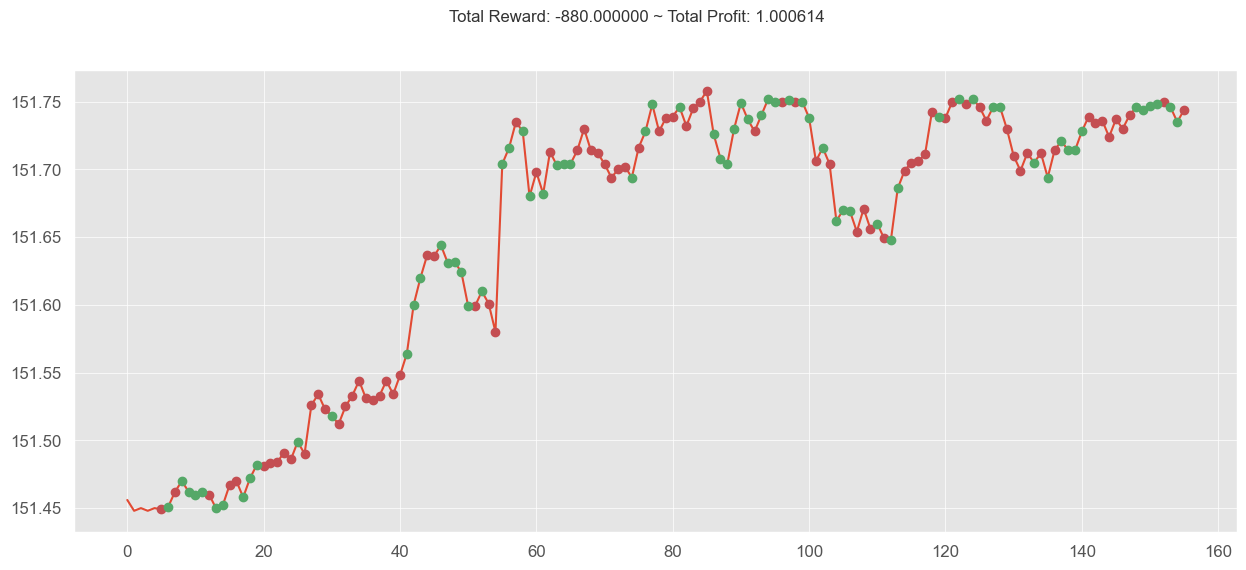

In [24]:
plt.figure(figsize=(15,6))
plt.cla()
env2.render_all()
plt.show()

In [25]:
env2.reset(seed=2023)
model = A2C('MlpPolicy', env2, verbose=1)
model.learn(total_timesteps=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 150       |
|    ep_rew_mean        | -1.69e+03 |
| time/                 |           |
|    fps                | 2862      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -0.0426   |
|    explained_variance | -3.4      |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 0.000131  |
|    value_loss         | 0.000452  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 150       |
|    ep_rew_mean        | -1.23e+03 |
| time/                 |           |
|    fps                | 2976      |
|    iterations         | 200   

In [28]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}
env2 = MyForexEnv(df=df, window_size=5, frame_bound=(int(len(df)*0.8), len(df)), unit_side='right')
observation, info = env2.reset(seed=2023)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env2.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env2.close()

print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 39, <Actions.Buy: 1>: 0}
info: {'total_reward': 0.0, 'total_profit': 1.0, 'position': <Positions.Short: 0>}


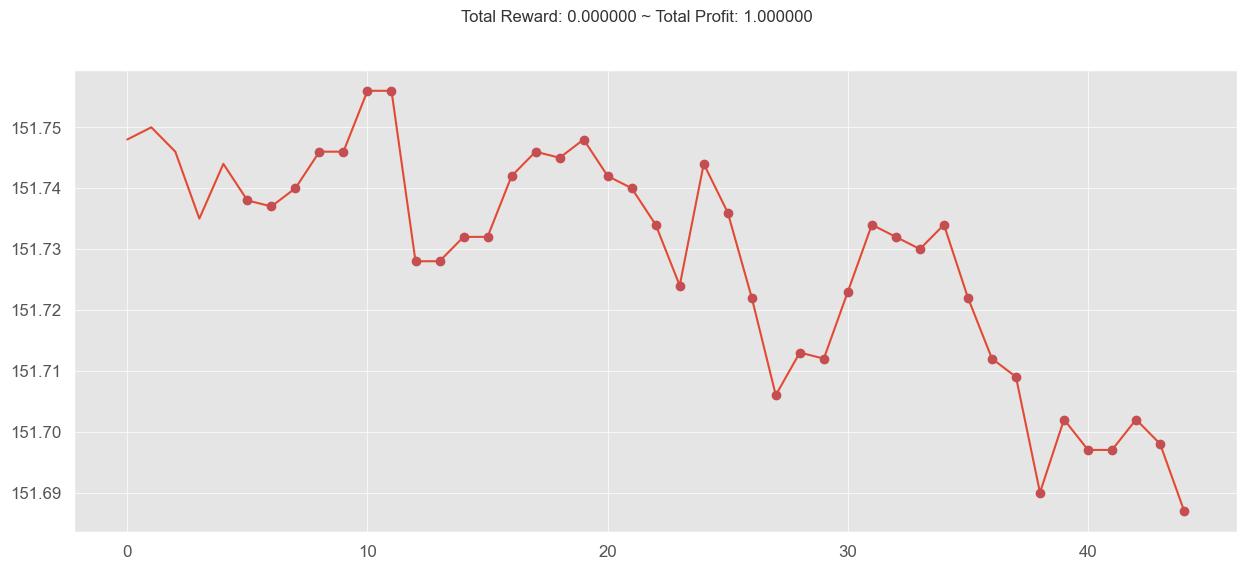

In [29]:
plt.figure(figsize=(15,6))
plt.cla()
env2.render_all()
plt.show()